In [1]:
from IPython.display import Audio

In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the NSynth dataset
dataset_train, dataset_test = tfds.load('nsynth', split=['train[:10%]', 'train[80%:]'])

In [2]:
del dataset_test

In [32]:
len(dataset_train)

28920

In [33]:
import random
import numpy as np

label_maps = {
    'bass':0,
    'brass':1,
    'flute':2,
    'guitar':3,
    'keyboard':4,
    'mallet':5,
    'organ':6,
    'reed':7,
    'string':8,
    'synth_lead':9
}

def get_other_instrument_audio(dataset, current_instrument_family, num_samples=1):
    """
    Select a specified number of random audio snippets from different instrument families.

    :param dataset: A dataset containing audio samples from various instruments.
    :param current_instrument_family: The instrument family of the current audio sample.
    :param num_samples: The number of different samples to return.
    :return: A list of numpy arrays, each containing audio from a different instrument.
    """
    # Filter the dataset to exclude the current instrument family
    other_instruments_dataset = [sample for sample in dataset if sample['instrument']['family'] != current_instrument_family]

    # Check if enough samples are available
    if len(other_instruments_dataset) < num_samples:
        raise ValueError("Not enough samples in the dataset for the requested number of samples")

    # Randomly select the specified number of samples from the filtered dataset
    selected_samples = random.sample(other_instruments_dataset, num_samples)

    # Extract and return the audio data from these samples
    return [sample['audio'].numpy() for sample in selected_samples]


In [68]:
import librosa
import numpy as np
from sklearn.decomposition import NMF
import tensorflow as tf

# Create dataset for training and testing
x_train = dict()
y_train = dict()


ins_to_test = ['flute']
num_random_ins = 1
for ins_family in ins_to_test:
  ins_class = label_maps[ins_family]
  filtered_dataset = dataset_train.filter(lambda x: x['instrument']['family'] == ins_class)
  ins_dict_key = str(ins_class)
  x_train = {**x_train, **{ins_dict_key:[]}}
  y_train = {**y_train, **{ins_dict_key:[]}}
  for sample in filtered_dataset:
    audio = sample['audio'].numpy()

    # add white noise
    noise = np.random.normal(0,0.01, audio.shape)
    noisy_audio = noise + audio
    stft_noise = librosa.stft(noisy_audio)
    mag_noisy, phase = librosa.magphase(stft_noise)


    x_train[ins_dict_key].append(mag_noisy.flatten())

    # add true label for white noise
    stft_clean = librosa.stft(audio)
    mag_clean, phase = librosa.magphase(stft_clean)
    y_train[ins_dict_key].append(mag_clean.flatten())

    # # add other instruments
    # for j in range(1, num_random_ins+1):
    #   other_instrument_audios = get_other_instrument_audio(dataset_train, ins_class, j)
    #   mixed_audio = audio

    #   for other_instrument_audio in other_instrument_audios:
    #     mixed_audio = mixed_audio + other_instrument_audio

    #   stft_mixed = librosa.stft(mixed_audio)
    #   mag_mixed, _ = librosa.magphase(stft_mixed)
    #   x_train[ins_dict_key].append(mag_mixed.flatten())

    #   # add true label for each instrument
    #   y_train[ins_dict_key].append(mag_clean.flatten())



In [35]:
assert len(x_train[str(ins_class)]) == len(y_train[str(ins_class)])
print("Num samples:",len(x_train[str(ins_class)]))

Num samples: 886


In [16]:
import json
import numpy as np

def save_dict_with_numpy_arrays(dict_to_save, filename):
    """
    Saves a dictionary containing NumPy arrays to a JSON file.

    :param dict_to_save: Dictionary with NumPy arrays.
    :param filename: Name of the file to save the JSON.
    """
    # Convert NumPy arrays to lists
    converted_dict = {key: [array.tolist() for array in value] for key, value in dict_to_save.items()}

    # Save the dictionary to a JSON file
    with open(filename, 'w') as file:
        json.dump(converted_dict, file)

def load_dict_with_numpy_arrays(filename):
    """
    Loads a dictionary with NumPy arrays from a JSON file.

    :param filename: Name of the file to load the JSON from.
    :return: Loaded dictionary with NumPy arrays.
    """
    # Load the JSON file
    with open(filename, 'r') as file:
        loaded_dict = json.load(file)

    # Convert lists back to NumPy arrays
    for key in loaded_dict:
        loaded_dict[key] = [np.array(lst) for lst in loaded_dict[key]]

    return loaded_dict


In [7]:
# Save x and y train in json file; files are large for 10% dataset, run only if you've space

save_dict_with_numpy_arrays(x_train, 'x_train.json')
save_dict_with_numpy_arrays(y_train, 'y_train.json')

In [ ]:
# load train data from json

x_train = load_dict_with_numpy_arrays(x_train, 'x_train.json')
y_train = load_dict_with_numpy_arrays(y_train, 'y_train.json')

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, TimeDistributed, Activation

#Define model

sample_rate = 16000
n_components = 2
input_shape = x_train[str(ins_class)][0].shape[0]
layer_size = 256
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_components*layer_size),
    tf.keras.layers.Activation(tf.keras.activations.softplus),
    tf.keras.layers.Dense(layer_size),
    tf.keras.layers.Activation(tf.keras.activations.softplus),
    tf.keras.layers.Dense(input_shape),
    tf.keras.layers.Activation(tf.keras.activations.softplus)
])
# model = Sequential([
#     # You might need to reshape your input accordingly
#     Conv1D(filters=layer_size, kernel_size=3, padding='same'),
#     Activation(tf.keras.activations.relu),
#     Bidirectional(LSTM(layer_size, return_sequences=True)),
#     TimeDistributed(Dense(n_components*layer_size)),
#     Activation(tf.keras.activations.softplus),
#     TimeDistributed(Dense(input_shape)),
#     Activation(tf.keras.activations.softplus)
# ])


def custom_loss_function(y_true, y_pred):
    # Ensure that the prediction values are within a valid range
    # y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute the loss using TensorFlow operations
    # loss = tf.reduce_sum(y_true * (tf.math.log(y_true) - tf.math.log(y_pred)) - y_true + y_pred)
    loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return loss

model.compile(optimizer='Adam', loss = custom_loss_function)



In [11]:
import soundfile as sf

global stft_shape

for sample in dataset_test.take(1):
  audio = sample['audio'].numpy()
  stft = librosa.stft(audio)
  mag, phase = librosa.magphase(stft)
  stft_shape = mag.shape

stft_shape
train_shape = np.array(x_train[str(ins_class)]).shape

(1025, 126)

In [12]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, Activation, Flatten

sample_rate = 16000
n_components = 2
n_samples = 190
input_shape = (129150, )  # Flattened spectrogram shape for each sample

# Assuming you've calculated these
time_steps = stft_shape[1]
frequency_bins = stft_shape[0]

layer_size = 256

model = Sequential([
    # Reshape the flattened spectrogram back into 2D format
    Reshape((time_steps, frequency_bins, 1), input_shape=input_shape),  # Add a channel dimension for the CNN

    # Convolutional layers
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and apply dense layers
    Flatten(),
    Dense(layer_size, activation='relu'),

    # Recurrent layer
    Reshape((-1, layer_size)),  # Reshaping for LSTM input
    Bidirectional(LSTM(layer_size, return_sequences=True)),

    # Output layer
    TimeDistributed(Dense(n_components * layer_size)),
    Activation('softplus'),
    TimeDistributed(Dense(input_shape[0])),
    Activation('softplus')
])


In [13]:

def custom_loss_function(y_true, y_pred):
    # Ensure that the prediction values are within a valid range
    # y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute the loss using TensorFlow operations
    # loss = tf.reduce_sum(y_true * (tf.math.log(y_true) - tf.math.log(y_pred)) - y_true + y_pred)
    loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return loss

model.compile(optimizer='Adam', loss = custom_loss_function)



In [39]:
model.fit(np.array(x_train[str(ins_class)]), np.array(y_train[str(ins_class)]), epochs=10, batch_size=4)

Epoch 1/10
222/222 [==============================] - 105s 467ms/step - loss: 56.4045
Epoch 2/10
222/222 [==============================] - 103s 464ms/step - loss: 45.8613
Epoch 3/10
222/222 [==============================] - 103s 464ms/step - loss: 40.9029
Epoch 4/10
222/222 [==============================] - 104s 468ms/step - loss: 38.7843
Epoch 5/10
222/222 [==============================] - 104s 471ms/step - loss: 35.4972
Epoch 6/10
222/222 [==============================] - 104s 468ms/step - loss: 34.9721
Epoch 7/10
222/222 [==============================] - 103s 466ms/step - loss: 32.3758
Epoch 8/10
222/222 [==============================] - 104s 469ms/step - loss: 31.3445
Epoch 9/10
222/222 [==============================] - 104s 468ms/step - loss: 31.1599
Epoch 10/10
222/222 [==============================] - 104s 467ms/step - loss: 30.5712


In [69]:
## Test set

import librosa
import numpy as np
from sklearn.decomposition import NMF
import tensorflow as tf

# Create dataset for training and testing
x_train = dict()
y_train = dict()



ins_to_test = ['flute']
num_random_ins = 1
for ins_family in ins_to_test:
  ins_class = label_maps[ins_family]
  filtered_dataset = dataset_test.filter(lambda x: x['instrument']['family'] == ins_class)
  ins_dict_key = str(ins_class)
  x_test = {**x_train, **{ins_dict_key:[]}}
  y_test = {**y_train, **{ins_dict_key:[]}}
  for sample in filtered_dataset:
    audio = sample['audio'].numpy()

    # add white noise
    noise = np.random.normal(0,0.01, audio.shape)
    noisy_audio = noise + audio
    stft_noise = librosa.stft(noisy_audio)
    mag_noisy, phase = librosa.magphase(stft_noise)


    x_test[ins_dict_key].append(mag_noisy.flatten())

    # add true label for white noise
    stft_clean = librosa.stft(audio)
    mag_clean, phase = librosa.magphase(stft_clean)
    y_test[ins_dict_key].append(mag_clean.flatten())

    # # add other instruments
    # for j in range(1, num_random_ins+1):
    #   other_instrument_audios = get_other_instrument_audio(dataset_train, ins_class, j)
    #   mixed_audio = audio

    #   for other_instrument_audio in other_instrument_audios:
    #     mixed_audio = mixed_audio + other_instrument_audio

    #   stft_mixed = librosa.stft(mixed_audio)
    #   mag_mixed, _ = librosa.magphase(stft_mixed)
    #   x_train[ins_dict_key].append(mag_mixed.flatten())

    #   # add true label for each instrument
    #   y_train[ins_dict_key].append(mag_clean.flatten())



In [70]:
mse = model.evaluate(np.array(x_test[str(ins_class)]), np.array(y_test[str(ins_class)]))

54/54 [==============================] - 2s 30ms/step - loss: 32.4378


In [71]:
mse

32.43780517578125

In [ ]:


import soundfile as sf

for sample in dataset_test.take():
  audio = sample['audio'].numpy()

  # Add noise to test input
  noise = np.random.normal(0,0.01, audio.shape)
  noisy_audio = noise + audio
  stft = librosa.stft(noisy_audio)
  sf.write('noisy.wav', noisy_audio, samplerate=sample_rate)

  mag_noisy, phase = librosa.magphase(stft)

  x_test = mag_noisy.flatten()
  x_test_reshaped = x_test.reshape(1, -1)  # Add batch dimension

  # Predict magnitude spectrogram
  predicted_mag = model.predict(x_test_reshaped)
  predicted_mag_reshaped = predicted_mag.reshape(mag_noisy.shape)
  reconstructed_stft = predicted_mag_reshaped * phase

  reconstructed_audio = librosa.istft(reconstructed_stft)

  # Normalize the reconstructed audio
  reconstructed_audio = np.float32(reconstructed_audio)
  max_val = max(reconstructed_audio.max(), -reconstructed_audio.min())
  reconstructed_audio /= max_val

  # Save to WAV file
  sf.write('pred.wav', reconstructed_audio, samplerate=sample_rate)

  # audio_stft = librosa.stft(audio)

  # audio_istft = librosa.istft(audio_stft)

  # Normalize the audio
  audio = np.float32(audio)
  max_val = max(audio.max(), -audio.min())
  audio /= max_val

  # Save to WAV file
  sf.write('true.wav', audio, samplerate=sample_rate)


In [57]:
from IPython.display import Audio

Audio('pred.wav')

In [58]:
from IPython.display import Audio

Audio('true.wav')

In [59]:
from IPython.display import Audio

Audio('noisy.wav')

# Appendix

In [40]:
!pip install mir_eval pystoi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100703 sha256=febdc610ac376da6e3eec1a650cc1c98319124da37bea43aaae5d05f37e2abb7
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7778 sha256=58bca33f7958b45de68a21337373b15e43490068a8234f6253a9c3e035ab70e3
  Stored in directory: /root/.cache/pip/wheels/3b/ca/9e/5b5d6e5e109322303b50d21918ad2bd7d50a2a0775c11e08e8
Successfully built mir_eval pystoi


SDR, SIR, SAR: 32.3215720668035 inf 32.3215720668035


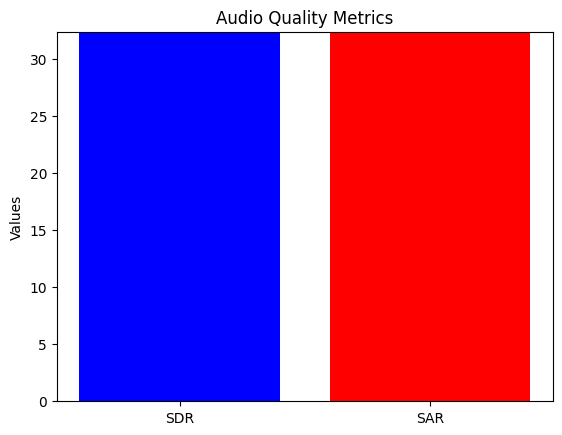

In [67]:
import numpy as np
import mir_eval
import pystoi
import librosa

def calculate_metrics(reference, estimated):
    # SDR, SIR, SAR calculation using mir_eval
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference, estimated)
    return sdr[0], sir[0], sar[0]

reference_signal, sr = librosa.load('true.wav', sr=None)
estimated_signal, sr = librosa.load('pred.wav', sr=None)
demuc_signal, sr = librosa.load('other.mp3', sr = sr)
sdr, sir, sar = calculate_metrics(reference_signal, demuc_signal[:64000])

print("SDR, SIR, SAR:", sdr, sir, sar)
## Visualize
import matplotlib.pyplot as plt

def plot_metrics(sdr, sar):
    metrics = ['SDR', 'SAR']
    values = [sdr, sar]
    plt.bar(metrics, values, color=['blue', 'red'])

    plt.title('Audio Quality Metrics')
    plt.ylabel('Values')
    plt.ylim(0, max(values) + 0.1)  # Adjust y-axis limits

    plt.show()


plot_metrics(sdr, sar)

In [64]:
# Adjusting the data for the box plot with the new provided values

# Updated values for SDR
min_sdr, q1_sdr, q3_sdr, max_sdr = 2, 6.3, 8.1, 9.3

# Updated values for SAR
min_sar, q1_sar, q3_sar, max_sar = 2.3, 6.75, 8.2, 9.2

# Creating data for box plot
data_sdr = [min_sdr, q1_sdr, avg_sdr, q3_sdr, max_sdr]  # [min, Q1, median, Q3, max] for SDR
data_sar = [min_sar, q1_sar, avg_sar, q3_sar, max_sar]  # [min, Q1, median, Q3, max] for SAR
data = [data_sdr, data_sar]  # Combining data

# Creating the plot
fig, ax = plt.subplots()

# Adding the boxplot
ax.boxplot(data, showmeans=True)

# Adding titles and labels
ax.set_xticklabels(['SDR', 'SAR'])
ax.set_ylabel('Values')
ax.set_title('Neural Net')

# Display the plot
plt.show()


NameError: ignored